In [1]:
#
# COMMENTS TO DO
#
#Condensed code based on the code from: https://jmetzen.github.io/2015-11-27/vae.html

%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import time
import glob

from tensorflow.examples.tutorials.mnist import input_data

def plot(samples, w, h, fw, fh, iw=28, ih=28):
    fig = plt.figure(figsize=(fw, fh))
    gs = gridspec.GridSpec(w, h)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(iw, ih), cmap='Greys_r')

    return fig


def encoder(images, num_outputs_h0=8, num_outputs_h1=16, kernel_size=5, stride=2, num_hidden_fc=1024, z_dim=100):
        
    print("Encoder")

    h0 = layers.convolution2d(
        inputs=images,
        num_outputs=num_outputs_h0,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (0,)
    )
    
    print("Convolution 1 -> {}".format(h0))

    h1 = layers.convolution2d(
        inputs=h0,
        num_outputs=num_outputs_h1,
        kernel_size=kernel_size,
        stride=stride,
        activation_fn=tf.nn.relu,
        scope='e_cnn_%d' % (1,)
    )
    
    print("Convolution 2 -> {}".format(h1))

    h1_dim = h1.get_shape().as_list()[1]

    h2_flat = tf.reshape(h1, [-1, h1_dim * h1_dim * num_outputs_h1])

    print("Reshape  -> {}".format(h2_flat))
    
    h2_flat =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='e_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h2_flat))

    z_mean =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (1,)
    )
    
    print("Z mean -> {}".format(z_mean))

    z_log_sigma_sq =layers.fully_connected(
        inputs=h2_flat,
        num_outputs=z_dim,
        activation_fn=None,
        scope='e_d_%d' % (2,)
    )

    return z_mean, z_log_sigma_sq 



def decoder(z, num_hidden_fc=1024, h1_reshape_dim=7, kernel_size=5, h1_channels=16, h2_channels = 8, output_channels=1, strides=2, output_dims=784):
    
    print("Decoder")
    
    batch_size = tf.shape(z)[0]  
    
    h0 =layers.fully_connected(
        inputs=z,
        num_outputs=num_hidden_fc,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (0,)
    )
    
    print("FC 1  -> {}".format(h0))

    h1 =layers.fully_connected(
        inputs=h0,
        num_outputs=h1_reshape_dim*h1_reshape_dim*h1_channels,
        activation_fn=tf.nn.relu,
        scope='d_d_%d' % (1,)
    )
    
    print("FC 2  -> {}".format(h1))

    h1_reshape = tf.reshape(h1, [-1, h1_reshape_dim, h1_reshape_dim, h1_channels])

    print("Reshape  -> {}".format(h1_reshape))

    wdd2 = tf.get_variable('wd2', shape=(kernel_size, kernel_size, h2_channels, h1_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd2 = tf.get_variable('bd2', shape=(h2_channels,), initializer=tf.constant_initializer(0))
    
    h2 = tf.nn.conv2d_transpose(h1_reshape, wdd2, output_shape=(batch_size, h1_reshape_dim*2,  h1_reshape_dim*2, h2_channels), strides=(1, strides, strides, 1), padding='SAME')

    h2_out = tf.nn.relu(h2 + bdd2)
    
    h2_out = tf.reshape(h2_out, (batch_size, h1_reshape_dim*2,  h1_reshape_dim*2, h2_channels))
    
    print("DeConv 1  -> {}".format(h2_out))
    
    h2_dim = h2_out.get_shape().as_list()[1]

    wdd3 = tf.get_variable('wd3', shape=(kernel_size, kernel_size, output_channels, h2_channels), initializer=tf.contrib.layers.xavier_initializer())
    bdd3 = tf.get_variable('bd3', shape=(output_channels,), initializer=tf.constant_initializer(0))
 
    h3 = tf.nn.conv2d_transpose(h2_out, wdd3, output_shape=(batch_size, h2_dim*2, h2_dim*2, output_channels), strides=(1, strides, strides, 1), padding='SAME')

    h3_out = tf.nn.sigmoid(h3 + bdd3)
    
    #Workaround to use dinamyc batch size...
    h3_out = tf.reshape(h3_out, (batch_size, h2_dim*2, h2_dim*2, output_channels))

    print("DeConv 2  -> {}".format(h3_out))

    h3_reshape = tf.reshape(h3_out, [-1, output_dims])
    
    print("Reshape  -> {}".format(h3_reshape))

    return h3_reshape
    

mnist = input_data.read_data_sets('DATASETS/MNIST_TF', one_hot=True)

#For reconstructing the same or a different image (denoising)
images = tf.placeholder(tf.float32, shape=(None, 784))

images_28x28x1 = tf.reshape(images, [-1, 28, 28, 1])

images_target = tf.placeholder(tf.float32, shape=(None, 784))

is_training_placeholder = tf.placeholder(tf.bool)
learning_rate_placeholder = tf.placeholder(tf.float32)

z_dim = 100

with tf.variable_scope("encoder") as scope:

    z_mean, z_log_sigma_sq = encoder(images_28x28x1)
    

with tf.variable_scope("reparameterization") as scope:
    
    eps = tf.random_normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0, dtype=tf.float32)

    # z = mu + sigma*epsilon
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    

with tf.variable_scope("decoder") as scope:
        
    x_reconstr_mean = decoder(z)
    
    scope.reuse_variables()

    ##### SAMPLING #######
    
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim])

    x_sample = decoder(z_input)


#reconstr_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_reconstr_mean, labels=images_target), reduction_indices=1)

offset=1e-7
obs_ = tf.clip_by_value(x_reconstr_mean, offset, 1 - offset)

reconstr_loss = -tf.reduce_sum(images_target * tf.log(obs_) + (1-images_target) * tf.log(1 - obs_), 1)

latent_loss = -.5 * tf.reduce_sum(1. + z_log_sigma_sq - tf.pow(z_mean, 2) - tf.exp(z_log_sigma_sq), reduction_indices=1)

cost = tf.reduce_mean(reconstr_loss + latent_loss)

optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder).minimize(cost)

Extracting ../../DATASETS/MNIST_TF/train-images-idx3-ubyte.gz
Extracting ../../DATASETS/MNIST_TF/train-labels-idx1-ubyte.gz
Extracting ../../DATASETS/MNIST_TF/t10k-images-idx3-ubyte.gz
Extracting ../../DATASETS/MNIST_TF/t10k-labels-idx1-ubyte.gz
Encoder
Convolution 1 -> Tensor("encoder/e_cnn_0/Relu:0", shape=(?, 14, 14, 8), dtype=float32)
Convolution 2 -> Tensor("encoder/e_cnn_1/Relu:0", shape=(?, 7, 7, 16), dtype=float32)
Reshape  -> Tensor("encoder/Reshape:0", shape=(?, 784), dtype=float32)
FC 1  -> Tensor("encoder/e_d_0/Relu:0", shape=(?, 1024), dtype=float32)
Z mean -> Tensor("encoder/e_d_1/BiasAdd:0", shape=(?, 100), dtype=float32)
Decoder
FC 1  -> Tensor("decoder/d_d_0/Relu:0", shape=(?, 1024), dtype=float32)
FC 2  -> Tensor("decoder/d_d_1/Relu:0", shape=(?, 784), dtype=float32)
Reshape  -> Tensor("decoder/Reshape:0", shape=(?, 7, 7, 16), dtype=float32)
DeConv 1  -> Tensor("decoder/Reshape_1:0", shape=(?, 14, 14, 8), dtype=float32)
DeConv 2  -> Tensor("decoder/Reshape_2:0", shape

In [2]:
init = tf.global_variables_initializer()

epochs = 1000
batch_size = 100

n_batches = mnist.train.images.shape[0]//batch_size

learning_rate=0.001

OUTPUT_PATH = "OUT_CVAE_MNIST_WITH_NOISE/"
MODELS_PATH = "MODELS_CVAE_MNIST/"

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

CVAE_SAVER = tf.train.Saver()

print("N. Batches: {}".format(n_batches))

# Launch the graph
with tf.Session() as sess:
    
    sess.run(init)
    
    for epoch in range(epochs):
        
        start_time = time.time()
        
        mean_loss = 0

        for n_batch in range(n_batches):
            
            batch_xs, _ = mnist.train.next_batch(batch_size)
            
            #from https://blog.keras.io/building-autoencoders-in-keras.html
            noise_factor = 0.5
            noise_batch_xs = batch_xs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=batch_xs.shape) 

            noise_batch_xs = np.clip(noise_batch_xs, 0., 1.)
            
            out_recon, out_latent_loss, out_cost, _ = sess.run([
                x_reconstr_mean, latent_loss, cost, optimizer], 
                           feed_dict={
                               images: noise_batch_xs, 
                               images_target: batch_xs, 
                               is_training_placeholder: True,
                               learning_rate_placeholder: learning_rate})


            mean_loss += out_cost
            #print(" Loss {}".format(out_cost))
        
           
        if epoch % 100 == 0:
            
            print("Epoch {}, Mean Loss {:.2f}, time: {}".format(epoch, mean_loss/n_batches, time.time() - start_time))
            
            fig=plot(noise_batch_xs, 10, 10, 10, 10)
            #plt.show()
            plt.savefig(OUTPUT_PATH + 'input_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
            plt.close(fig)
            
            fig=plot(batch_xs, 10, 10, 10, 10)
            #plt.show()
            plt.savefig(OUTPUT_PATH + 'target_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
            plt.close(fig)

            fig=plot(out_recon, 10, 10, 10, 10)
            #plt.show()
            plt.savefig(OUTPUT_PATH + 'output_{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
            plt.close(fig)

            

    # Save model weights to disk
    save_path = CVAE_SAVER.save(sess, MODELS_PATH + 'CONV_VAE_MNIST_WITH_NOISE.ckpt')
    print("Model saved in file: {}".format(save_path))

N. Batches: 550
Epoch 0, Mean Loss 191.10, time: 2.2477805614471436
Epoch 100, Mean Loss 96.13, time: 1.9355757236480713
Epoch 200, Mean Loss 94.73, time: 1.9176478385925293
Epoch 300, Mean Loss 94.08, time: 1.91062331199646
Epoch 400, Mean Loss 93.57, time: 2.178285598754883
Epoch 500, Mean Loss 93.30, time: 1.9225618839263916
Epoch 600, Mean Loss 93.09, time: 1.904773235321045
Epoch 700, Mean Loss 92.94, time: 1.9082765579223633
Epoch 800, Mean Loss 92.73, time: 1.9017186164855957
Epoch 900, Mean Loss 92.58, time: 1.89512300491333
Model saved in file: MODELS_CVAE_MNIST/CONV_VAE_MNIST.ckpt


Model restored in file: MODELS_CVAE_MNIST/CONV_VAE_MNIST.ckpt


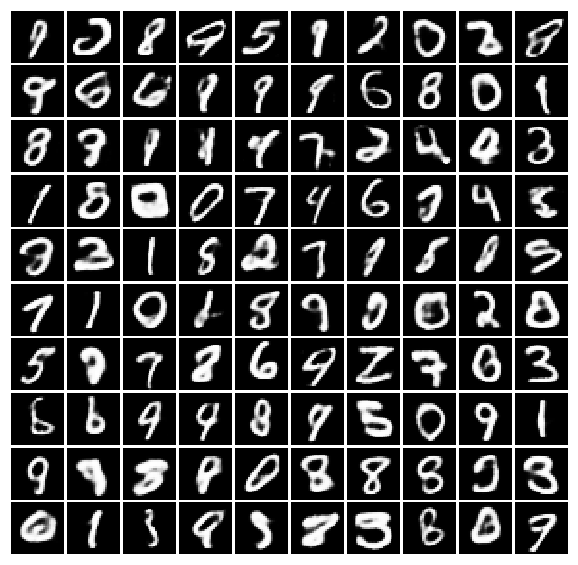

In [4]:
with tf.Session() as sess:
    
    sess.run(init)

    CVAE_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    random_gen = sess.run(x_sample,feed_dict={z_input: np.random.randn(100, z_dim)})
    
    fig=plot(random_gen, 10, 10, 10, 10)
    plt.show()

    
                            

Model restored in file: MODELS_CVAE_MNIST/CONV_VAE_MNIST.ckpt


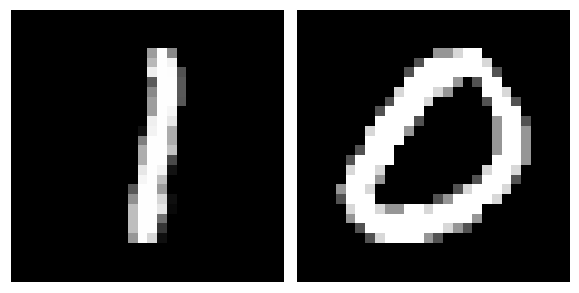

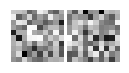

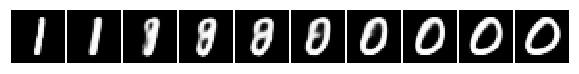

In [12]:
with tf.Session() as sess:
    
    sess.run(init)

    CVAE_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    INTERPOLATION_STEPS = 10
    alphaValues = np.linspace(0, 1, INTERPOLATION_STEPS)
    
    random_indexes = np.random.permutation(mnist.train.images.shape[0])[:2]
    
    x_samples = mnist.train.images[random_indexes].copy()
    
    z_projected_samples = sess.run(z, feed_dict={images: x_samples})
    
    fig=plot(x_samples, 1, 2, 10, 10)
    plt.show()
    
    fig=plot(z_projected_samples, 10, 10, 10, 10, 10, 10)
    plt.show()
    
    z_samples_interpolated = np.zeros((INTERPOLATION_STEPS, z_dim))
    
    for i, alpha in enumerate(alphaValues):
        z_samples_interpolated[i] = z_projected_samples[0]*(1-alpha) + z_projected_samples[1]*alpha
        
    
    x_interpolated = sess.run(x_sample, feed_dict={z_input: z_samples_interpolated})
    
    fig=plot(x_interpolated, 1, INTERPOLATION_STEPS, 10, 10)
    plt.show()
    
    
    